# Stochastic Diversity Evaluation for BCQ

Because BCQ is a generative model, it can generate different actions for the same state. This example code explores its capabilities of producing diverse, meaningful results.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import normalize

from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def load_file(path, name):
    import importlib.util
    spec = importlib.util.spec_from_file_location(name, path)
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    return mod

models = load_file("../../utils/models.py", "models")
data = load_file("../../utils/data.py", "data")
plot = load_file("../../utils/plot.py", "plot")

cuda = torch.device('cuda')
frame_size = 10
# https://drive.google.com/open?id=1xjVI4uVQGsQ7tjOJ3594ZXmAEC_6yX0e
meta = json.load(open('../../data/metadata.json'))
tqdm.pandas()

In [3]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movie_ref = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))
movie_ref_tensor, key_to_id, id_to_key = data.make_movie_tensor(movie_ref)
# download ml20m dataset yourself
ratings = pd.read_csv('../../data/ml-20m/ratings.csv')
user_dict, users = data.prepare_tensor(ratings, key_to_id, frame_size)
del ratings
gc.collect()
clear_output(True)
clear_output(True)
print('Done!')

Done!


In [4]:
perturbator = models.bcqPerturbator(1290, 128, 256).to(cuda)
generator = models.bcqGenerator(1290, 128, 512).to(cuda)
perturbator.load_state_dict(torch.load('../../models/BCQ/bcq_policy.pt'))
generator.load_state_dict(torch.load('../../models/BCQ/bcq_vae.pt'))

<All keys matched successfully>

In [5]:
test_users = users[-5000:]
batch_size = 25

def prepare_batch_wrapper(x):
    batch = data.prepare_batch(x, movie_ref_tensor, frame_size=frame_size)
    return batch

test_user_dataset = data.UserDataset(test_users, user_dict)
test_dataloader = DataLoader(test_user_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4,collate_fn=prepare_batch_wrapper)
test_batch = next(iter(test_dataloader))
state = test_batch[0].to(cuda)

In [6]:
def rank(gen_action, metric):
    scores = []
    for i in movie_ref.keys():
        scores.append([i, metric(movie_ref[i], gen_action)])
    scores = list(sorted(scores, key = lambda x: x[1]))
    scores = scores[:10]
    ids = [i[0] for i in scores]
    dist = [i[1] for i in scores]

    return ids, dist

import faiss
# test indexes
indexL2 = faiss.IndexFlatL2(128)
indexIP = faiss.IndexFlatIP(128)
indexCOS = faiss.IndexFlatIP(128)

mov_mat  = np.stack(movie_ref.values()).astype('float32')
indexL2.add(mov_mat)
indexIP.add(mov_mat)
indexCOS.add(normalize(mov_mat, axis=1, norm='l2'))


def query(index, action, k=20):
    D, I = index.search(action, k)
    return D, I

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [8]:
# more than 5 actions don't work, the graphic looks ugly
# though you can change top k ranking
state = torch.repeat_interleave(state[0].unsqueeze(0), 5, dim=0)
sampled_actions = generator.decode(state)
perturbed_actions= perturbator(state, sampled_actions)
bcq_action = perturbed_actions

### Euclidean and cosine distances between generated actions for the same state

/home/dev/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


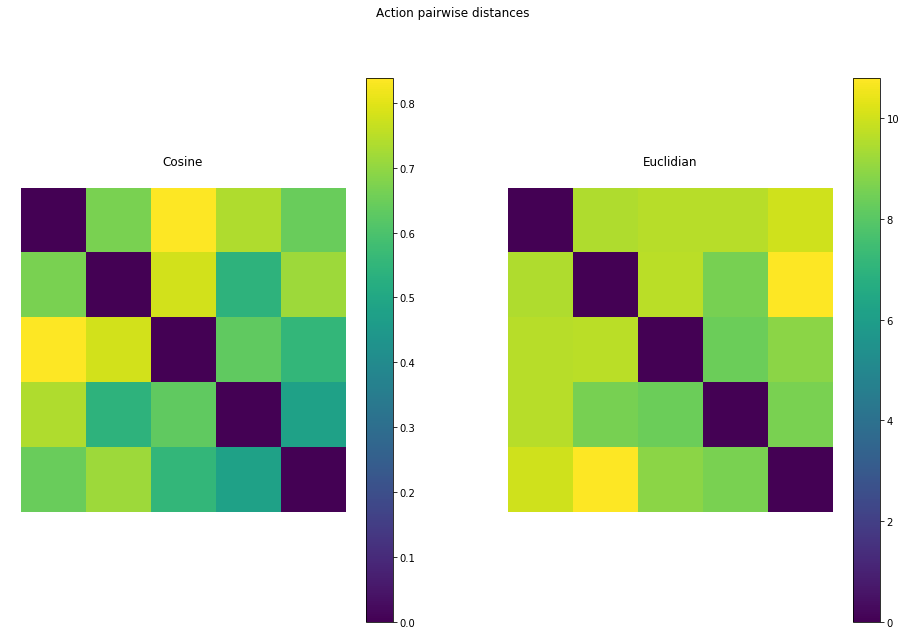

In [9]:
plot.embed_show(bcq_action)

## PyUpSet
### bokeh version in the next section

In [10]:
# you will need to build it yourself:
# git clone github.com/pedromiravaz/py-upset
# cd py-upset
# python setup.py install
# note pip install pyupset or cloning ImSoErgodic repo DOES NOT WORK

import pyupset as pyu

In [11]:
bcq_action = bcq_action.detach().cpu().numpy()

In [12]:
D, I = query(indexL2, bcq_action, 10)
cat = dict([['a' + str(k), []] for k in range(I.shape[0])])
for r in range(I.shape[0]):
    cat['a' + str(r)] =  pd.DataFrame({'id': I[r]})

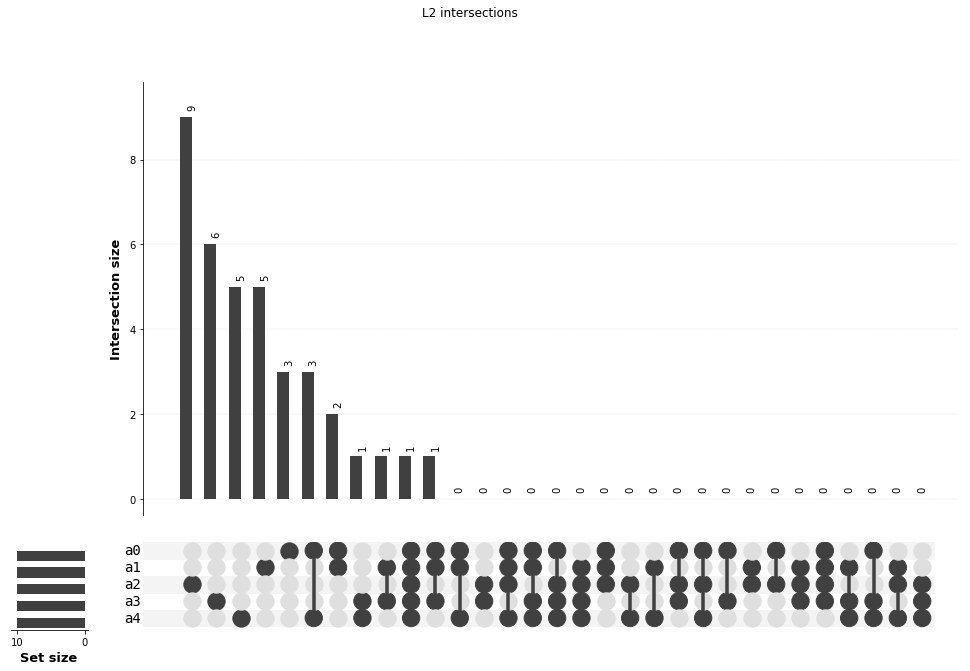

In [13]:
import warnings
warnings.filterwarnings("ignore")
pyu.plot(cat)
plt.suptitle('L2 intersections')
print()

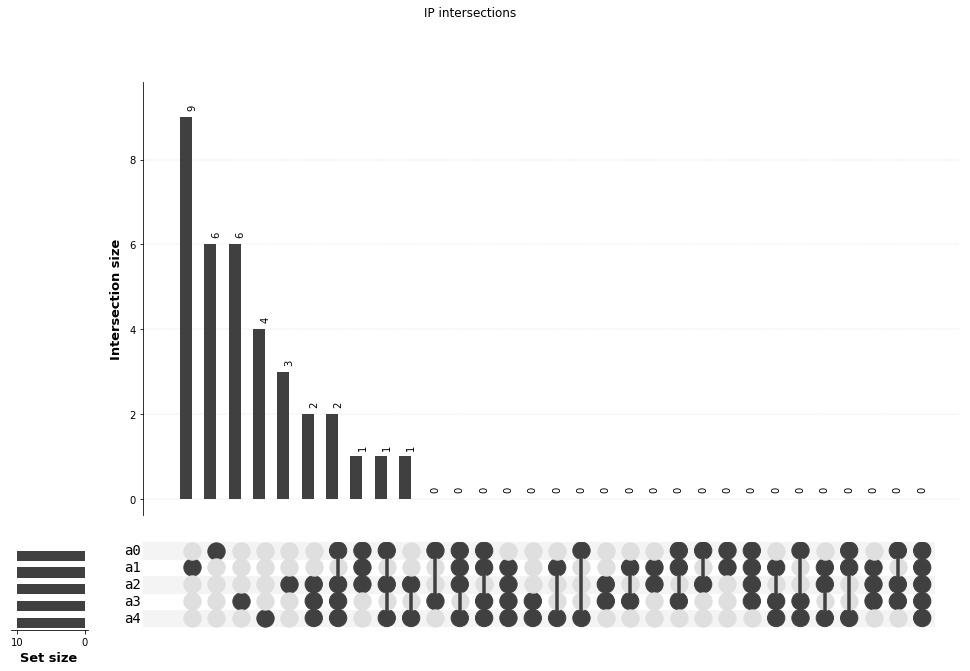

In [14]:
D, I = query(indexIP, bcq_action, 10)
cat = dict([['a' + str(k), []] for k in range(I.shape[0])])
for r in range(I.shape[0]):
    cat['a' + str(r)] =  pd.DataFrame({'id': I[r]})
pyu.plot(cat)
plt.suptitle('IP intersections')
print()

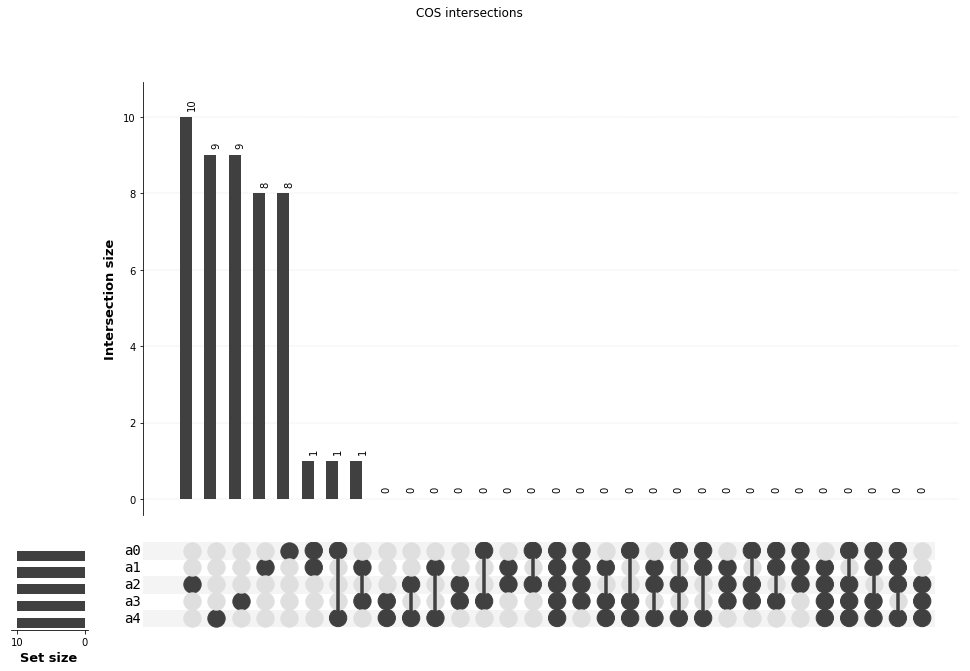

In [15]:
D, I = query(indexCOS, normalize(bcq_action, axis=1, norm='l2'), 10)
cat = dict([['a' + str(k), []] for k in range(I.shape[0])])
for r in range(I.shape[0]):
    cat['a' + str(r)] =  pd.DataFrame({'id': I[r]})
pyu.plot(cat)
plt.suptitle('COS intersections')
print()

## Distance Matrices

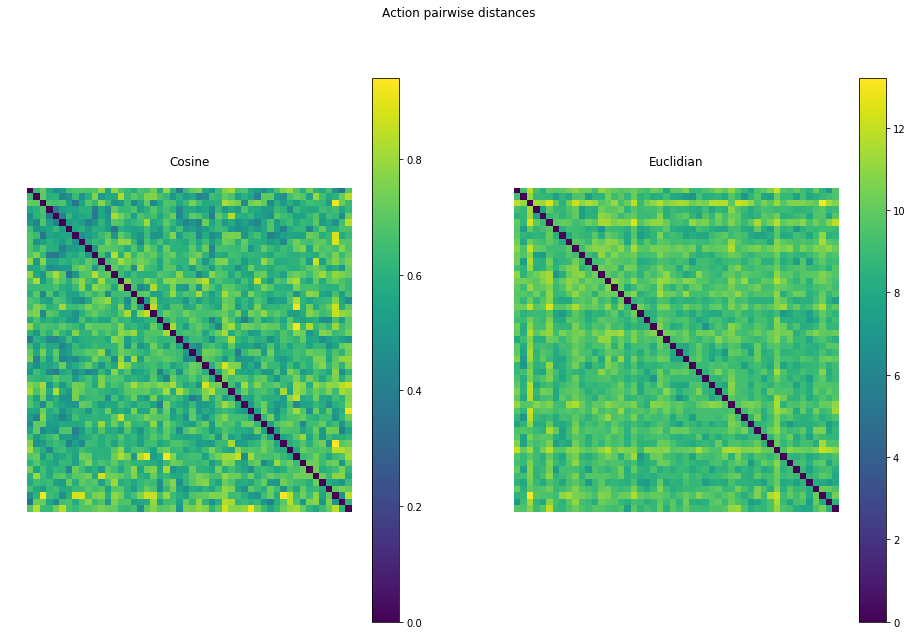

In [17]:
state = torch.repeat_interleave(state[0].unsqueeze(0), 50, dim=0)
sampled_actions = generator.decode(state)
perturbed_actions= perturbator(state, sampled_actions)
bcq_action = perturbed_actions
plot.embed_show(bcq_action)

cosine dist is pretty small

# Holoviews Chord diagram

In [18]:
# can someone do this please?